# Rossmann Store Sales

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import csv
from sklearn.model_selection import train_test_split
import datetime
import warnings
warnings.filterwarnings('ignore')
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
%matplotlib inline

## Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [2]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe_xg(y_pred, y):
    y = y.get_label()
    y = np.exp(y) - 1
    y_pred = np.exp(y_pred) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - y_pred)**2))
    return "rmspe", rmspe

## Cargar datasets

In [3]:
nrows = None

df_train = pd.read_csv('dataset/rossmann/train.csv', 
                       nrows=nrows,
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

nrows = nrows

df_submit = pd.read_csv('dataset/rossmann/test.csv', 
                        nrows=nrows,
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

# Setting a variable to easily distinguish train (1) from submit (0) set
df_train['Set'] = 1
df_submit['Set'] = 0
# Combine train and test set
frames = [df_train, df_submit]
df = pd.concat(frames)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1058297 non-null  int64         
 1   DayOfWeek      1058297 non-null  int64         
 2   Date           1058297 non-null  datetime64[ns]
 3   Sales          1017209 non-null  float64       
 4   Customers      1017209 non-null  float64       
 5   Open           1058286 non-null  float64       
 6   Promo          1058297 non-null  int64         
 7   StateHoliday   1058297 non-null  object        
 8   SchoolHoliday  1058297 non-null  int64         
 9   Set            1058297 non-null  int64         
 10  Id             41088 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 96.9+ MB


In [4]:
# Features y target
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [5]:
# Remove rows where store is open, but no sales.
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]
# Log and cat
df.loc[df['Set'] == 1, 'SalesLog'] = np.log1p(df.loc[df['Set'] == 1]['Sales'])
df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes

In [6]:
var_name = 'Date'

df[var_name + 'Day'] = pd.Index(df[var_name]).day
df[var_name + 'Week'] = pd.Index(df[var_name]).week
df[var_name + 'Month'] = pd.Index(df[var_name]).month
df[var_name + 'Year'] = pd.Index(df[var_name]).year
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear

df[var_name + 'Day'] = df[var_name + 'Day'].fillna(0)
df[var_name + 'Week'] = df[var_name + 'Week'].fillna(0)
df[var_name + 'Month'] = df[var_name + 'Month'].fillna(0)
df[var_name + 'Year'] = df[var_name + 'Year'].fillna(0)
df[var_name + 'DayOfYear'] = df[var_name + 'DayOfYear'].fillna(0)

features_x.remove(var_name)
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

df['DateInt'] = df['Date'].astype(np.int64)

## Cargar data Store

In [7]:
df_store = pd.read_csv('dataset/rossmann/store.csv', 
                       nrows=nrows)
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [8]:
# Convert Storetype and Assortment to numerical categories
df_store['StoreType'] = df_store['StoreType'].astype('category').cat.codes
df_store['Assortment'] = df_store['Assortment'].astype('category').cat.codes

In [9]:
def monthToNum(date):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[date]

s = df_store['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
df_store = df_store.join(s)

df_store['PromoInterval0'] = df_store['PromoInterval0'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval1'] = df_store['PromoInterval1'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval2'] = df_store['PromoInterval2'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval3'] = df_store['PromoInterval3'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

del df_store['PromoInterval']

In [10]:
store_features = ['Store', 'StoreType', 'Assortment', 
                  'CompetitionDistance',
                  'PromoInterval0']
# Combinar features unicos entre datas
features_x = list(set(features_x + store_features))

In [11]:
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [12]:
# Convert every NAN to -1
for feature in features_x:
    df[feature] = df[feature].fillna(-1)

## Remove Outliers with Deviation >= 3

In [13]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [14]:
for i in df['Store'].unique():
    df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1)]['Sales'], 3)

## Split Data in Training and Test

In [15]:
split_type = 'random'
# Semilla 
seed = 42

if split_type == 'no_split':
    # Esta es para entrenar con todo
    X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_x],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_y],
                                                    test_size=0.0, random_state=seed)
elif split_type == 'last_week':
    # Esto divide en train y val
    X_train = df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False) & (df.Date < datetime.datetime(2015, 7, 1))][features_x]
    X_test = df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False) & (df.Date >= datetime.datetime(2015, 7, 1))][features_x]
    y_train = df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False) & (df.Date < datetime.datetime(2015, 7, 1))][features_y]
    y_test = df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False) & (df.Date >= datetime.datetime(2015, 7, 1))][features_y]
elif split_type == 'random':
    # Random split
    X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_x],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_y],
                                                    test_size=0.1, random_state=seed)
    
print(f'Cantidad en val: {len(y_test)}, porcentaje: {np.round(100 * len(y_test)/(len(y_train) + len(y_test)), 2)}' + '%')

Cantidad en val: 83136, porcentaje: 10.0%


## Entrenamiento y busqueda de hiperparametros

In [16]:
last_score = 9999
# Funcion Objetivo para busqueda de hiperparametros
def objective(params):
    global last_score
    params['objective'] = 'reg:linear'
    params['nthread'] = 6
    params['seed'] = seed
    params['subsample'] = 0.8
    try:
        # Entrenar modelo XGBoost
        clf = xgb.train(params, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)
        # Score a minimizar
        score = clf.best_score
        last_score = score
    except:
        score = last_score
    return score

In [17]:
# Definir Train y Test (Val)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [18]:
# Parametros XGBoost

num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

space = {
    'learning_rate': hp.loguniform('learning_rate', -3, -1),
    'max_depth':  hp.choice('max_depth', list(np.arange(1, 31))),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0), # enabler of bagging fraction
    'reg_lambda': hp.loguniform('reg_lambda',-8, -3), # L2 regularization
    'reg_alpha': hp.loguniform('reg_alpha',-8, -3), # L1 regularization
    'min_child_weight': hp.loguniform('min_child_weight',-8, -1) # Minimum sum of instance weight (hessian) needed in a child (leaf). 
}

# Buscar hiperparametros
best = fmin(fn=objective,
            space=space,
            verbose=2,
            algo=tpe.suggest,
            max_evals=25)

[11:53:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:7.72325	train-rmspe:0.99969	test-rmse:7.72302	test-rmspe:0.99969                                        

[250]	train-rmse:0.01755	train-rmspe:0.01756	test-rmse:0.09085	test-rmspe:0.10116                                      

[451]	train-rmse:0.00867	train-rmspe:0.00867	test-rmse:0.09130	test-rmspe:0.10168                                      

[12:10:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:7.60196	train-rmspe:0.99963	test-rmse:7.60168	test-rmspe:0.99963                                        

[250]	train-rmse:0.05395	train-rmspe:0.05487	test-rmse:0.09211	test-rmspe:0.10212                                      

[500]	train-rmse:0.03231	train-rmspe:0.03

In [19]:
best['objective'] = 'reg:linear'
best['nthread'] = 6
best['seed'] = seed
best['subsample'] = 0.8
# Mejores hiperparametros
print(best)

{'colsample_bytree': 0.5180777869846886, 'learning_rate': 0.060614560472884174, 'max_depth': 10, 'min_child_weight': 0.002308003899171486, 'reg_alpha': 0.04856702315354391, 'reg_lambda': 0.000798411237239631, 'objective': 'reg:linear', 'nthread': 6, 'seed': 42, 'subsample': 0.8}


In [20]:
# Entrenar con mejores hiperparametros
clf = xgb.train(best, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)
clf.best_score

[18:54:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:7.75878	train-rmspe:0.99970	test-rmse:7.75842	test-rmspe:0.99970
[250]	train-rmse:0.14001	train-rmspe:0.18602	test-rmse:0.14386	test-rmspe:0.15586
[500]	train-rmse:0.10722	train-rmspe:0.15218	test-rmse:0.11307	test-rmspe:0.12266
[750]	train-rmse:0.09358	train-rmspe:0.12514	test-rmse:0.10143	test-rmspe:0.11031
[1000]	train-rmse:0.08649	train-rmspe:0.09647	test-rmse:0.09611	test-rmspe:0.10493
[1250]	train-rmse:0.08099	train-rmspe:0.08778	test-rmse:0.09236	test-rmspe:0.10126
[1500]	train-rmse:0.07663	train-rmspe:0.08077	test-rmse:0.08995	test-rmspe:0.09894
[1750]	train-rmse:0.07356	train-rmspe:0.07711	test-rmse:0.08854	test-rmspe:0.09763
[2000]	train-rmse:0.07093	train-rmspe:0.07394	test-rmse:0.08741	test-rmspe:0.09671
[2250]	train-rmse:0.06860	train-rmspe:0.07107	test-rmse:0.08666	test-rmspe:0.09602

0.095347

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

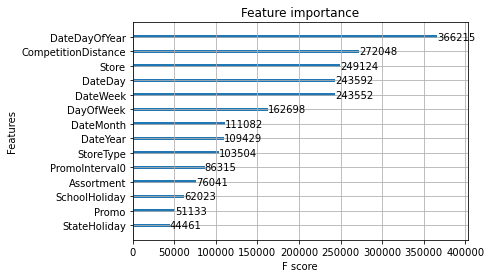

In [21]:
# Feature importance
xgb.plot_importance(clf)

## Submit

In [22]:
X_submit = df.loc[df['Set'] == 0]
dsubmit = xgb.DMatrix(X_submit[features_x])

In [23]:
ypred_bst = clf.predict(dsubmit)

df_ypred = X_submit['Id'].reset_index()
del df_ypred['index']
df_ypred['Id'] = df_ypred['Id'].astype('int')

# Scale back the sales a bit
df_ypred['Sales'] = (np.exp(ypred_bst) - 1) * 0.985

df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_xgb.csv', index=False)